In [1]:
import numpy as np
import pandas as pd
import os, sys

In [2]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

import pandas as pd
import sonnet as snt

from filterflow.smc import SMC
from filterflow.base import State, StateWithMemory, StateSeries, DTYPE_TO_OBSERVATION_SERIES, DTYPE_TO_STATE_SERIES

from filterflow.observation.base import ObservationModelBase, ObservationSampler
from filterflow.observation.linear import LinearObservationSampler
from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.transition.base import TransitionModelBase

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import RicattiSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

In [3]:
data_dir = "../../data/covid"
os.listdir(data_dir)

['covid.csv']

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'covid.csv'))

In [5]:
df.loc[df.geoId =='UK']

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
15104,09/05/2020,9,5,2020,4649,626,United_Kingdom,UK,GBR,66488991.0,Europe
15105,08/05/2020,8,5,2020,5514,539,United_Kingdom,UK,GBR,66488991.0,Europe
15106,07/05/2020,7,5,2020,6211,649,United_Kingdom,UK,GBR,66488991.0,Europe
15107,06/05/2020,6,5,2020,4406,693,United_Kingdom,UK,GBR,66488991.0,Europe
15108,05/05/2020,5,5,2020,3985,288,United_Kingdom,UK,GBR,66488991.0,Europe
...,...,...,...,...,...,...,...,...,...,...,...
15230,04/01/2020,4,1,2020,0,0,United_Kingdom,UK,GBR,66488991.0,Europe
15231,03/01/2020,3,1,2020,0,0,United_Kingdom,UK,GBR,66488991.0,Europe
15232,02/01/2020,2,1,2020,0,0,United_Kingdom,UK,GBR,66488991.0,Europe
15233,01/01/2020,1,1,2020,0,0,United_Kingdom,UK,GBR,66488991.0,Europe


In [6]:
df.loc[df.geoId =='UK', 'deaths'].sum()

31241

Infections model (Latent state evolution):
\begin{align}
    S_t &= S_{t-1}-\beta S_{t-1}I_{t-1}/N \\
    E_t &= (1-\alpha)E_{t-1}+\beta S_{t-1} I_{t-1}/N \\
    I_t &= (1-\gamma+\epsilon_t) I_{t-1}+\alpha E_{t-1}\\
    R_t &= R_{t-1} + \gamma I_{t-1}  ~\mathbf{\text{not needed}}\\
    \epsilon_t &\sim \mathcal{N}(0,1)\\
\end{align}

Death Model (Observation Model):
\begin{align}
d_t &= \delta_t I_t \\
    D_t - D_{t-1} &\sim \text{NegBinom}(d_t, d_t + \frac{d_t^2}{\Psi}) \\
    \Psi &\sim \mathcal{N}^+(0,5)
\end{align}

In [7]:
batch_size = 1
n_particles = 1000
dimension = 1


In [8]:
def split_sei(x):
    S, E, I = tf.split(x, 3, axis=-1)
    return S,E,I

def join_sei(S,E,I):
    x = tf.concat([S,E, I], axis=-1)
    return x

def zero_state(batch_size, num_particles, dimension):
    uniform_dist = tfp.distributions.Uniform()
    x = uniform_dist.sample([batch_size, n_particles, 3*dimension])
    return split_sei(x)

    


In [9]:
alpha = 1.
beta = 1.
gamma = 1.
delta = 1.
T = 150
population_size = 100

In [34]:
class SEIRTransitionModel(TransitionModelBase):
    def __init__(self, alpha, beta, gamma, population_size, name='SEIRTransitionModel'):
        super(SEIRTransitionModel, self).__init__(name=name)
        self.normal_dist = tfp.distributions.Normal(loc=tf.constant(0.), scale=tf.constant(1.))
        self.beta = beta
        self.alpha = alpha
        self.gamma = gamma
        self.pop = population_size
        
    def _loglikelihood(self, prior_state: State, proposed_state: State):
        St_1, Et_1, It_1 = split_sei(prior_state.particles)
        St, Et, It = split_sei(proposed_state.particles)
        
        eps = (It - (1.-self.gamma)*It_1 - self.alpha*Et_1) / It_1
        log_prob = tf.reduce_sum(self.normal_dist.log_prob(eps), axis=-1)
        return log_prob
    
    def loglikelihood(self, prior_state: State, proposed_state: State, inputs: tf.Tensor):
        return self._loglikelihood(prior_state, proposed_state)

    def sample(self, state: State, inputs: tf.Tensor):
        St_1, Et_1, It_1 = split_sei(state.particles)
        
        eps = self.normal_dist.sample()
        
        St = St_1 - self.beta*St_1*It_1/self.pop
        Et = (1-self.alpha) * Et_1 + self.beta*St_1*It_1/self.pop

        It = (1-self.gamma+eps)*It_1 + self.alpha*Et_1
        
        x = join_sei(St, Et, It)
        
        return State(particles=x, 
                     log_weights = state.log_weights,
                     weights=state.weights, 
                     log_likelihoods=state.log_likelihoods)


In [76]:
class SEIRProposalModel(SEIRTransitionModel):
    def __init__(self, alpha, beta, gamma, population_size, name ='SEIRProposalModel'):
        super(SEIRProposalModel, self).__init__(alpha, beta, gamma, population_size, name=name)

    def loglikelihood(self, proposed_state: State, state: State, inputs: tf.Tensor, observation: tf.Tensor):
        return self._loglikelihood(state, proposed_state)
    
    def propose(self, state: State, inputs: tf.Tensor, observation: tf.Tensor):
        return self.sample(state, None)

In [77]:
class SEIRObservationModel(ObservationSampler):
    
    def __init__(self, delta, name='SEIRObservationModel'):
        super(SEIRObservationModel, self).__init__(name=name)
        self.half_norm_dist = tfp.distributions.HalfNormal(scale = tf.constant(5.))
        self.delta = delta
            
    def loglikelihood(self, state: State, observation: tf.Tensor):
        S, E, I = split_sei(state.particles)
        dt = self.delta*I
        psi = self.half_norm_dist.sample()
        nb_dist = tfp.distributions.NegativeBinomial(total_count=psi, probs=psi/(psi+dt))
        log_prob = self.half_norm_dist.log_prob(psi)+ tf.reduce_sum(nb_dist.log_prob(observation-dt), axis=-1)
        return log_prob
        

    def sample(self, state: State):
        S, E, I = split_sei(state.particles)
        dt = self.delta*I
        psi = self.half_norm_dist.sample()
        nb_dist = tfp.distributions.NegativeBinomial(total_count=psi, probs=psi/(psi+dt))
        
        dt1 = nb_dist.sample() + dt
        return dt1

In [78]:
transition_model = SEIRTransitionModel(alpha, beta, gamma, population_size)
proposal_model = SEIRProposalModel(alpha, beta, gamma, population_size)
observation_model = SEIRObservationModel(delta)

In [79]:
uniform_dist = tfp.distributions.Uniform()
initial_particles = uniform_dist.sample([batch_size, n_particles, 3*dimension])

initial_particles = tf.cast(initial_particles, dtype=float)

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods)

In [80]:
new_state = transition_model.sample(initial_state, None)

In [81]:
loglik = transition_model.loglikelihood(initial_state, new_state, None)

In [82]:
new_obs = observation_model.sample(initial_state)
log_prob = observation_model.loglikelihood(initial_state, new_obs)

In [83]:
# Generate data
states = []
observations = []
state = initial_state
for i in range(T):
    state = transition_model.sample(state, None)
    observation = observation_model.sample(new_state)
    states.append(new_state)
    observations.append(observation)
    

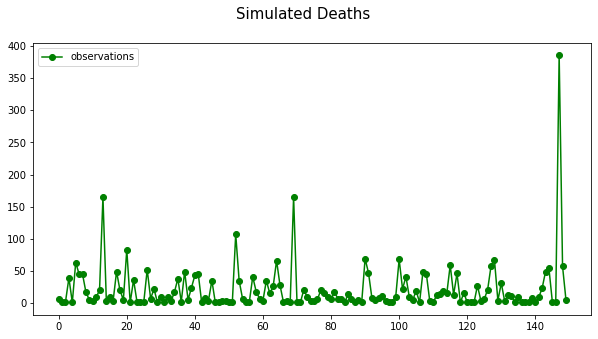

In [84]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])

linspace  = np.arange(T)
fig, axes = plt.subplots(nrows=1, figsize=(10, 5))
axes.plot(linspace, np_obs[:,0], marker='o', color='g', label='observations')
_ = axes.legend(loc='upper left')
_ = fig.suptitle('Simulated Deaths', fontsize=15)

In [85]:
obs_data = tf.data.Dataset.from_tensor_slices(observations)
inputs_data = tf.data.Dataset.from_tensor_slices([tf.constant(0.) for _ in range(T)])

In [86]:
# resampling
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()
multinomial = MultinomialResampler()


epsilon = tf.constant(0.25)
scaling = tf.constant(0.9)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4)

In [88]:
particle_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, regularized)

recorded_states = particle_filter(initial_state, observation_series=obs_data, n_observations=T, inputs_series = inputs_data)

recorded_states  = attr.evolve(recorded_states)

ht = np.array([state.particles.numpy() for state in states]).squeeze()

In [ ]:
observations